# 👕 Fashion MNIST CNN Projesi (PyTorch)

Bu projede, **PyTorch** kullanarak *Fashion MNIST* veri seti üzerinde sıfırdan bir **Convolutional Neural Network (CNN)** modeli oluşturacağız.

### 🎯 Amaç
- CNN mimarisini adım adım öğrenmek  
- `Dropout` ve `Batch Normalization` etkilerini gözlemlemek  
- `Adam` ve `SGD` optimizer’larını karşılaştırmak  
- Eğitim ve doğrulama sonuçlarını görselleştirmek  

---

### 📚 Kullanılan Kütüphaneler
- **torch, torchvision** → Derin öğrenme modeli oluşturmak  
- **matplotlib, numpy** → Görselleştirme ve temel analizler  


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
print("PyTorch versiyonu:", torch.__version__)


PyTorch versiyonu: 2.8.0+cu126


Eğitim veri seti boyutu: 60000
Test veri seti boyutu: 10000


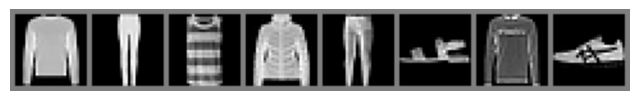

Labeles:  ['Pullover', 'Trouser', 'T-shirt/top', 'Coat', 'Trouser', 'Sandal', 'Pullover', 'Sneaker']


In [3]:
# Görsellerin dönüştürülmesi (Tensor +Normalize)
transform= transforms.Compose([
    transforms.ToTensor(),
    # Ortalama ve Standart Sapma
    transforms.Normalize((0.5),(0.5))
])

# Eğitim ve Test veri setleri
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size =64, shuffle =True)
test_loader = DataLoader(test_dataset,batch_size =64,shuffle=False)

print(f"Eğitim veri seti boyutu: {len(train_dataset)}")
print(f"Test veri seti boyutu: {len(test_dataset)}")

#Sınıfı İsimleri

classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
           'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Görselleştirme
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
  img = img/2+0.5  #Normalize geri alma
  npimg = img.numpy()
  plt.figure(figsize=(8,4))
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.axis("off")
  plt.show()

imshow(torchvision.utils.make_grid(images[:8]))
print("Labeles: ",[classes[labels[j]] for j in range(8)])


# CNN Model Tanımı


In [4]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN,self).__init__()
    #Gri resim kanal =1, 32 adet feature map üretilecek, kernel=3x3
    self.conv1 = nn.Conv2d(1,32,3,padding=1)
    # Batch Normalization(Katmandan çıkan aktivasyonları normalize eder)
    self.bn1 = nn.BatchNorm2d(32)
    # 64 feature map çıkar
    self.conv2 = nn.Conv2d(32,64,3,padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2,2)
    # %25 nöronu kapatır.Overfit engellenir
    self.dropout = nn.Dropout(0.25)

    #Full Connected Layer
    self.fc1 = nn.Linear(64*7*7,128)
    # 10 sınıf var
    self.fc2 = nn.Linear(128,10)

  def forward(self,x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(-1,64 * 7 * 7)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
model = FashionCNN()
print(model)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Dropout-7             [-1, 64, 7, 7]               0
            Linear-8                  [-1, 128]         401,536
            Linear-9                   [-1, 10]           1,290
Total params: 421,834
Trainable params: 421,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated Total Size (MB): 2.28
-------------------------------------------

In [12]:
from torchviz import make_dot
x = torch.randn(1, 1, 28, 28)
y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("cnn_graph", format="png")


'cnn_graph.png'

In [11]:
!pip install torchviz


# Eğitim Fonksiyonu

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
      model.train()
      running_loss =0.0

      for images,labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      # Test Doğruluğu
      model.eval()
      correct,total = 0,0
      with torch.no_grad():
        for images,labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      acc = 100 * correct /total
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(acc)
      print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc:.2f}%")

    return train_losses, test_losses




# ADAM ve SVG Karşılaştırması

In [8]:
criterion = nn.CrossEntropyLoss()

# Model 1 - Adam
model_adam = FashionCNN()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
adam_loss, adam_acc = train_model(model_adam, train_loader, test_loader, criterion, optimizer_adam, epochs=5)

# Model 2 - SGD
model_sgd = FashionCNN()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)
sgd_loss, sgd_acc = train_model(model_sgd, train_loader, test_loader, criterion, optimizer_sgd, epochs=5)


Epoch [1/5] | Loss: 0.3901 | Accuracy: 88.08%
Epoch [2/5] | Loss: 0.2718 | Accuracy: 90.19%
Epoch [3/5] | Loss: 0.2371 | Accuracy: 90.34%
Epoch [4/5] | Loss: 0.2132 | Accuracy: 91.23%
Epoch [5/5] | Loss: 0.1934 | Accuracy: 91.50%
Epoch [1/5] | Loss: 0.4359 | Accuracy: 88.01%
Epoch [2/5] | Loss: 0.2973 | Accuracy: 89.82%
Epoch [3/5] | Loss: 0.2608 | Accuracy: 89.80%
Epoch [4/5] | Loss: 0.2318 | Accuracy: 90.89%
Epoch [5/5] | Loss: 0.2134 | Accuracy: 91.33%


# Sonuçları Karşılaştırma

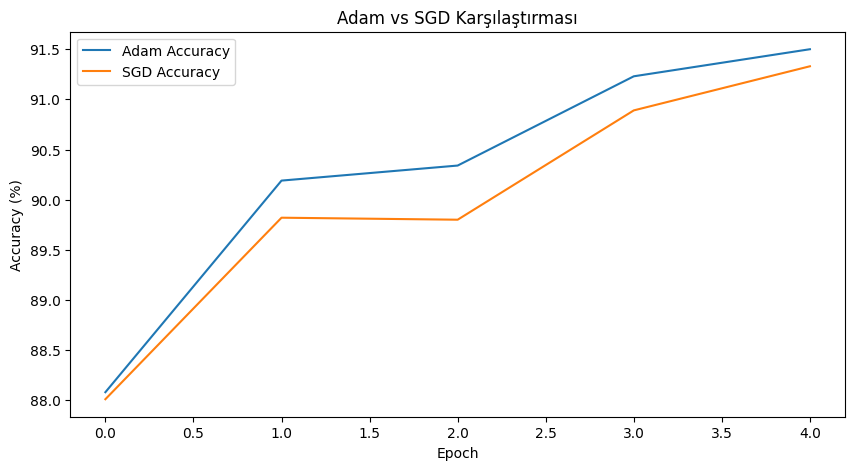

In [9]:
plt.figure(figsize=(10,5))
plt.plot(adam_acc, label='Adam Accuracy')
plt.plot(sgd_acc, label='SGD Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Adam vs SGD Karşılaştırması')
plt.legend()
plt.show()
